In [2]:
%run './model/multi_corpus.py'
%run './constants.py'

from matplotlib import cm
from collections import Counter

In [3]:
corpora = citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies DiGraph with 2224 nodes and 4332 edges
Geometry DiGraph with 2121 nodes and 2652 edges
Geophysics DiGraph with 38952 nodes and 162177 edges
Economics DiGraph with 7147 nodes and 55537 edges
Language & Linguistics DiGraph with 3128 nodes and 13572 edges
Probability & Statistics DiGraph with 5496 nodes and 19273 edges
Material Engineering DiGraph with 39045 nodes and 253189 edges
Artificial Intelligence DiGraph with 5475 nodes and 21705 edges
Sociology DiGraph with 4083 nodes and 25676 edges
International Business DiGraph with 5254 nodes and 36786 edges
Political Science DiGraph with 5305 nodes and 26335 edges
Genetics & Genomics DiGraph with 26776 nodes and 109991 edges
Immunology DiGraph with 27301 nodes and 195148 edges
Human Resources & Organizations DiGraph with 5848 nodes and 34965 edges
Ethnic & Cultural Studies DiGraph with 2105 nodes and 4041 edges
Neurology DiGraph with 32881 nodes and 282230 edges


/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_24814/3081138980.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


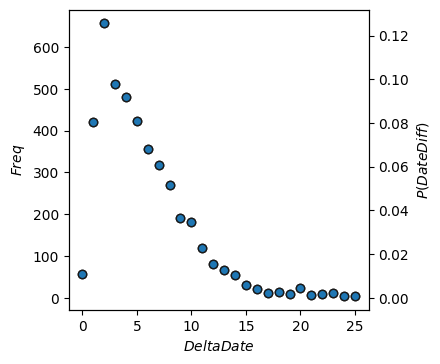

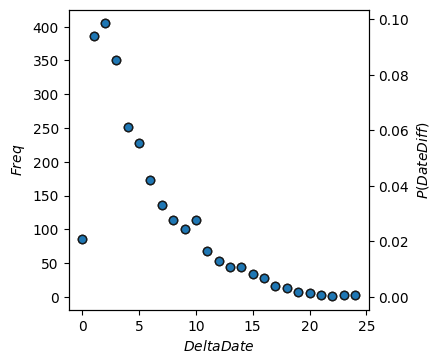

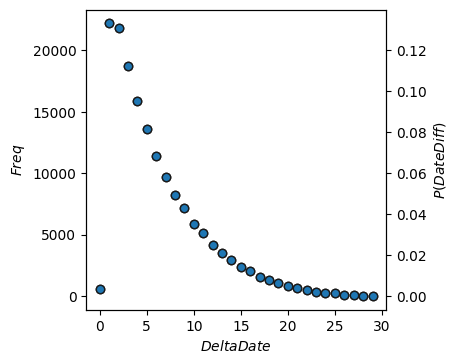

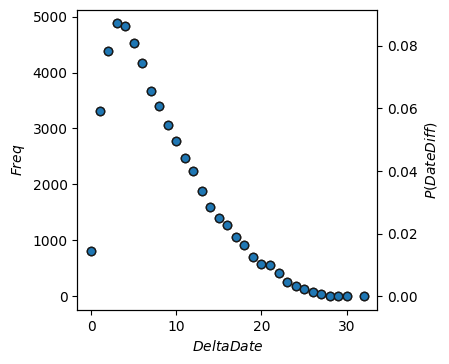

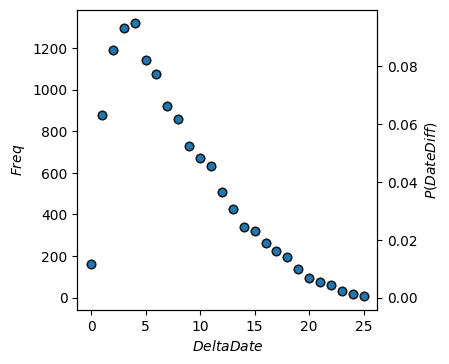

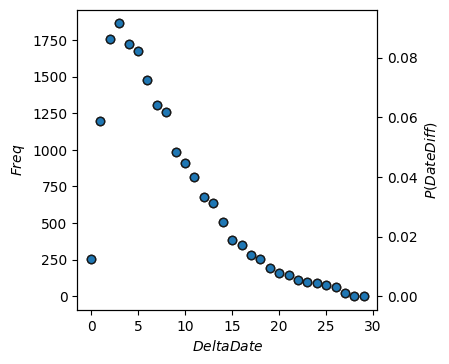

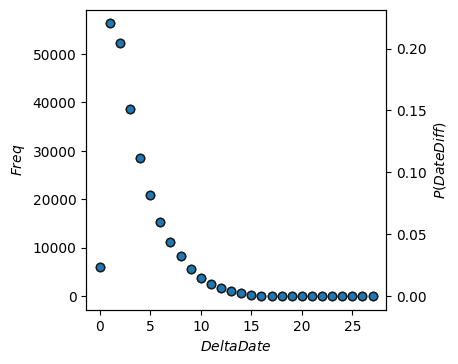

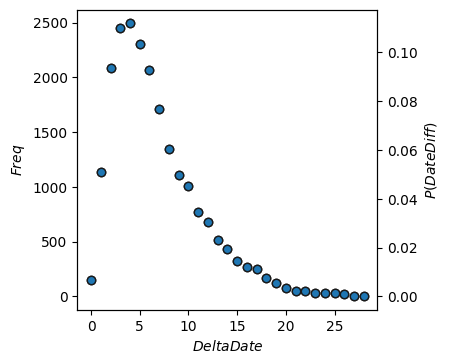

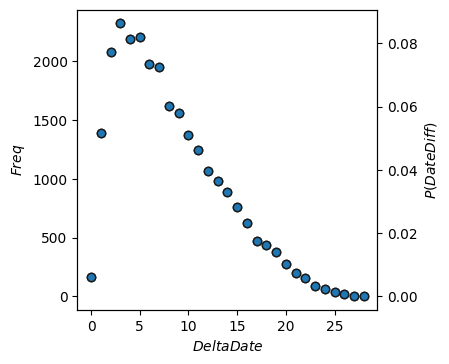

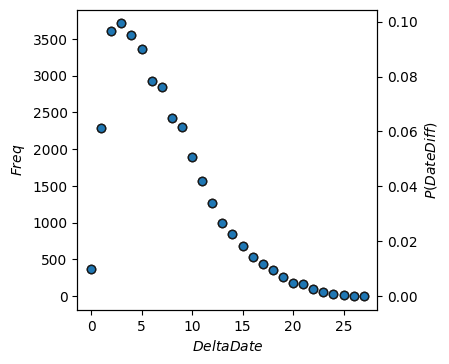

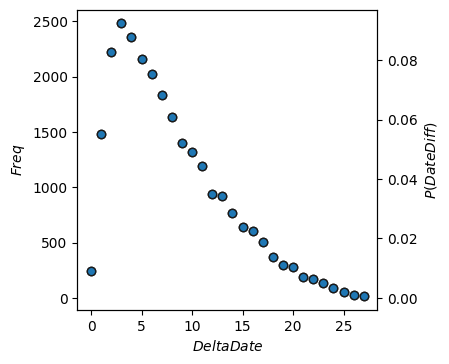

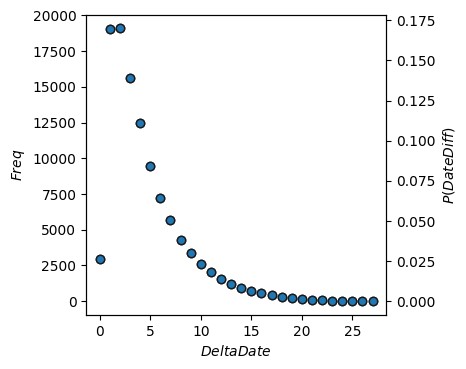

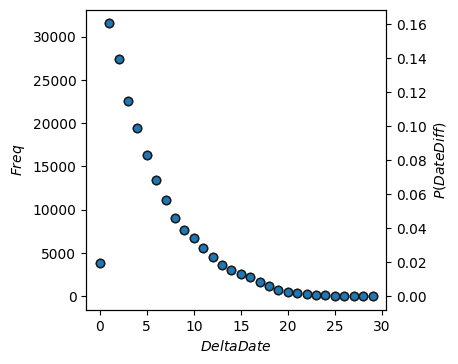

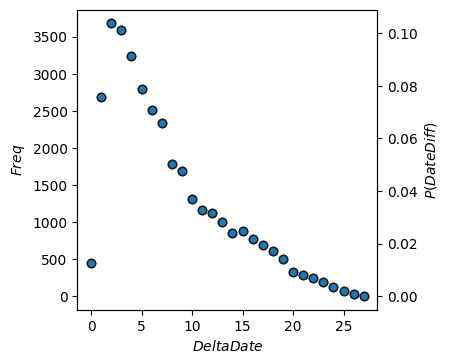

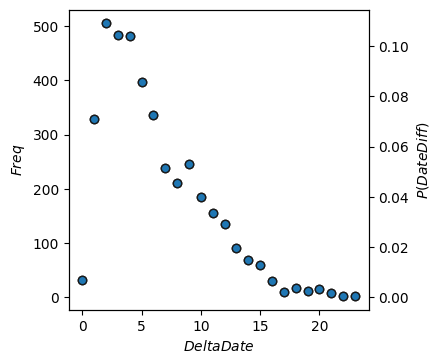

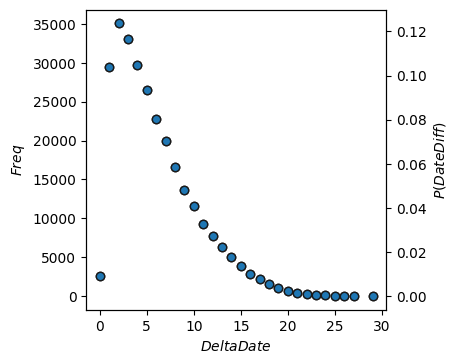

In [104]:

sns.reset_defaults()

for field_name, df in Dfs.items():

    df = (
        df
        .select(pl.col('Doi'), pl.col('Date'), pl.col('References'))
        .explode('References')
        .join(other=df.select('Doi', 'Date'), left_on='References', right_on='Doi', how='left', suffix='References')
        .with_columns((pl.col('Date').dt.year() - pl.col('DateReferences').dt.year()).alias('DateDiff'))
    )

    dates = df['DateDiff']
    date, freq = zip(*Counter(dates).items())
    pk = np.array(freq) / np.sum(freq)


    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_axes([0, 0, 1, 1])

    ax.plot(date, freq, 'o', markeredgewidth=1, markeredgecolor='k')
    # ax.plot(k, target_func(k, *popt), '--')
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('$Delta Date$')
    ax.set_ylabel('$Freq$')

    ax1 = ax.twinx()
    ax1.plot(date, pk, 'o', markeredgewidth=1, markeredgecolor='k')

    # ax1.set_yscale('log')
    # ax1.set_xscale('log')
    ax1.set_ylabel('$P(Date Diff)$')

    ax.grid(False)

    fig.tight_layout()

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'citation_ref_dates', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=150,
        bbox_inches='tight'
    )

In [103]:
d = {'': ['Mean', 'Std', 'Min', 'Max']}
for field_name, df in Dfs.items():
    d[field_name] = (
        df
        .select(pl.col('Doi'), pl.col('Date'), pl.col('References'))
        .explode('References')
        .join(other=df.select('Doi', 'Date'), left_on='References', right_on='Doi', how='left', suffix='References')
        .with_columns((pl.col('Date').dt.year() - pl.col('DateReferences').dt.year()).alias('DateDiff'))
        .select(
            pl.col('DateDiff').mean().alias('Mean'),
            pl.col('DateDiff').std().alias('Std'),
            pl.col('DateDiff').min().alias('Min'),
            pl.col('DateDiff').max().alias('Max'),
        ).row(0)
    )
df = pl.DataFrame(d)

# new_cols = []
# for col in df.columns:
#     if '&' in col:
#         # \makecell{Some really \\ longer text}
#         col = ' & '.join(col.split('&'))
#     new_cols.append(col)
# df.columns = new_cols

latex = (
    df
    .to_pandas()
    .to_latex(
        index=False,
        na_rep=' ',
        bold_rows=True,
        float_format="%.2f",
    )
)

newline_splits = latex.split('\n')
col_labels = newline_splits[2]

new_cols_labels = []
for col_label in col_labels.split(' &  '):
    if '&' in col_label:
        col_label = col_label.split('\\&')
        col_label = ' \\& \\\\ '.join(col_label)
        # \begin{tabular}{cc} Artificial \\ Intelligence \end{tabular} 
        col_label = '\\begin{tabular}{cc} ' + col_label + ' \end{tabular}'
    new_cols_labels.append(col_label)

new_cols_labels = ' & '.join(new_cols_labels)
newline_splits[2] = new_cols_labels
latex = ' \n'.join(newline_splits)

print(latex)

with open(os.path.join(LATEX_TABLE_PATH, 'citation_ref_dates.tex'), 'w+') as file:
    file.write(latex)
    
# # df

\begin{tabular}{lrrrrrrrrrrrrrrrr} 
\toprule 
     & Gender Studies & Geometry & Geophysics & Economics & \begin{tabular}{cc} Language  \& \\  Linguistics \end{tabular} & \begin{tabular}{cc} Probability  \& \\  Statistics \end{tabular} & Material Engineering & Artificial Intelligence & Sociology & International Business & Political Science & \begin{tabular}{cc} Genetics  \& \\  Genomics \end{tabular} & Immunology & \begin{tabular}{cc} Human Resources  \& \\  Organizations \end{tabular} & \begin{tabular}{cc} Ethnic  \& \\  Cultural Studies \end{tabular} & Neurology \\ 
\midrule 
Mean &            5.53 &      5.18 &        6.02 &       7.93 &                    7.33 &                      7.57 &                  3.54 &                     6.65 &       8.02 &                    6.94 &               7.81 &                 4.44 &        5.37 &                             7.40 &                       5.98 &       5.92 \\ 
 Std &            4.07 &      4.23 &        4.81 &       5.46 &       

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_24814/2023738656.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df
